In [5]:
# Тюнинг
import optuna as opt
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# Данные
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer

%matplotlib inline

In [10]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def save_submission(model, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    preds = model.predict(test_df)
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка
train_df = pd.read_csv(TRAIN_DATASET)
train_df = train_df.drop_duplicates()
balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
train_df = balanced_df
test_df = pd.read_csv(TEST_DATASET)

first_negatives = train_df[train_df['y'] == 0][:train_df[train_df['y'] == 1]['y'].count()]
train_df = pd.concat([train_df[train_df['y'] == 1], first_negatives])

# Нормализация
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = pd.concat([X_train, y_train], axis=1)

train_df = train_df[train_df['Длительность'] < 400]
train_df = train_df[(train_df['Сумма'] > 2) & (train_df['Сумма'] < 10)]
train_df = train_df[train_df['До поставки'] < 300]
train_df = train_df[train_df['Дней между 0_1'] < 400]

y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [11]:
# Категориальные фичи
cat_features = [
    'Purchasing Organization', 'Delivery Option', 
    'Company Code', 'Provider', 'Provider Delivery option', 
    'Provider Purchaser', 'Operations Manager', 'Sum Fold',
    'Month1', 'Month2', 'Month3', 'Weekday', 'Material Group',
    'Purchasing Group', 'EI'
    ]

# Фичи на масштабирование
scale_features = [
    'Position Count', 'Duration', 'ETC Delivery',
    'Changes After Approvals', 'Order Approval 1', 'Order Approval 2',
    'Order Approval 3', 'Sum', 'Change Delivery Date 7', 'Change Delivery Date 15', 
    'Change Delivery Date 30', 'Approval Cycles',
    'Handlers 7', 'Handlers 15', 'Handlers 30',
    'Days Between 0_1', 'Days Between 1_2', 'Days Between 2_3', 
    'Days Between 3_4', 'Days Between 4_5',
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8',
    'Amount', 'ETC Difference'
]

# Фичи на дроп
drop_features = [
    'Material', 'Cancel Complete Release',
    'Delivery Date', 'Change on Paper', 
    'Category Manager', 'NRP'
    ]

# Новые имена фич
rename_cols = [
    'Provider', 'Material', 'Category Manager', 'Operations Manager',
    'Factory', 'Purchasing Organization', 'Purchasing Group', 
    'Company Code', 'EI', 'Material Group', 'Delivery Option', 'NRP',
    'Duration', 'ETC Delivery', 'Month1', 'Month2', 'Month3', 'Weekday',
    'Sum', 'Position Count', 'Amount', 'Handlers 7', 'Handlers 15', 
    'Handlers 30', 'Order Approval 1', 'Order Approval 2', 'Order Approval 3',
    'Change Delivery Date 7', 'Change Delivery Date 15', 'Change Delivery Date 30',
    'Cancel Complete Release', 'Change on Paper', 'Delivery Date', 
    'Approval Cycles', 'Changes After Approvals', 'Days Between 0_1', 
    'Days Between 1_2', 'Days Between 2_3', 'Days Between 3_4', 'Days Between 4_5', 
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8'
    ]

In [12]:
# Препроцессоры
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """ Предобработчик данных """
    def __init__(self, cat_features, scale_features,
                 drop_features, rename_cols, transform_train=True):
        self.transform_train = transform_train
        self.cat_features = cat_features

        self.bin_encoder = BinaryEncoder(cols=cat_features)
        self.robust_scaler = RobustScaler()

        self.rename_cols = rename_cols

        self.drop_features = drop_features
        self.scale_features = scale_features

    def fit(self, X, y=None):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x % 10))
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']

        # Нормализация
        self.robust_scaler.fit(X_[self.scale_features])

        # Категориальные фичи        
        X_ = self.bin_encoder.fit_transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)
        
        return self
    
    def transform(self, X):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x % 10))
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']

        # Нормализация
        X_[self.scale_features] = self.robust_scaler.transform(X_[self.scale_features])

        # Категориальные фичи
        X_ = self.bin_encoder.transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)

        return X_

In [9]:
# Функция оптимизации
def objective(trial: opt.Trial):
    # Параметры
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1)
    n_estimators = trial.suggest_int('n_estimators', 700, 1500)
    max_depth = trial.suggest_int('max_depth', 6, 16)
    max_bin = trial.suggest_int('max_bin', 64, 256),
    num_leaves = trial.suggest_int('num_leaves', 32, 128)
    reg_lambda = trial.suggest_float('l2_reg', 0.1, 1)

    # Модель
    data_preprocessor = DataPreprocessor(cat_features, scale_features, drop_features, rename_cols)
    model = LGBMClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        max_bin=max_bin,
        n_jobs=-1,
        force_col_wise=True
    )

    pipeline = Pipeline([
        ('data_preproc', data_preprocessor),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=8), scoring='f1_macro', n_jobs=-1)
    accuracy = cv_score.mean()

    return accuracy

In [13]:
best_params = {
    'learning_rate': 0.3, 
    'n_estimators': 1500, 
    'max_depth': 16, 
    'max_bin': 160, 
    'num_leaves': 180,
    'reg_lambda': 0.2,
    }

# Модель
data_preprocessor = DataPreprocessor(cat_features, scale_features, drop_features, rename_cols)
power = PowerTransformer()
quantile = QuantileTransformer(random_state=42)
model = LGBMClassifier(
    **best_params,
    n_jobs=-1,
    force_col_wise=True,
    # is_unbalance=True,
    objective='binary'
)

pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

In [89]:
pipeline.fit(X_general, y_general)
preds = pipeline.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 193374, number of negative: 192237
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 385611, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501474 -> initscore=0.005897
[LightGBM] [Info] Start training from score 0.005897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [92]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.9997665961408266
0.9997652503932678


In [14]:
pipeline.fit(X_general, y_general)
preds = pipeline.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 189666, number of negative: 188089
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 377755, number of used features: 121
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502087 -> initscore=0.008349
[LightGBM] [Info] Start training from score 0.008349


In [15]:
save_submission(pipeline, 'submission')

In [94]:
# Сабмит
preds = pipeline.predict(test_df)
submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})

In [95]:
submit_df.to_csv('sub_9.csv', index=False)

In [96]:
submit_df

,id,value
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
24995,24995,0
24996,24996,1
24997,24997,1
24998,24998,1


In [97]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

ValueError: Found input variables with inconsistent numbers of samples: [38562, 25000]

<Axes: >

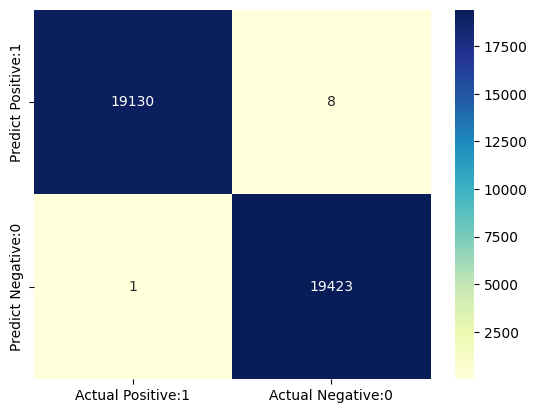

In [32]:
import seaborn as sns
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19378
           1       1.00      1.00      1.00     19291

    accuracy                           1.00     38669
   macro avg       1.00      1.00      1.00     38669
weighted avg       1.00      1.00      1.00     38669



In [109]:
import numpy as np

def cumulative_mean_2d(X):
    def cumulative_mean(X):
        spam = np.cumsum(X)
        k = np.array([i+1 for i in range(len(X))])
        result = spam / k
        return result

    data = np.array([cumulative_mean(c) for c in X])
    result = data
    return data

X = np.array([[1, 2, 3],

       [4, 5, 6]])
cumulative_mean_2d(X)

array([[1. , 1.5, 2. ],
       [4. , 4.5, 5. ]])